In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
from glob import glob
import joblib

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm.auto import tqdm
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)

cuda Tesla P100-PCIE-16GB


In [4]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [5]:
config = AttrDict()

config.n_epoch = 100
config.batch_size = 64
config.learning_rate = 1e-3
config.b1 = 0.5
config.b2 = 0.999

config.augmentation = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean = [0.5], std = [0.5])
                                        ])
config.denormalize = lambda x: x*0.5 + 0.5
config.data_path = '/content/drive/MyDrive/Implement/data/SISR'
config.B200 = config.data_path + '/BSDS200/BSDS200' 
config.B100 = config.data_path + '/BSDS100/BSDS100/'
config.G100 = config.data_path + '/General100/General100/'

# preprocess data path
config.dataset_G100 = '/content/drive/MyDrive/Implement/data/SISR/General100/FSRCNN/'
config.dataset_B100 = '/content/drive/MyDrive/Implement/data/SISR/BSDS100/FSRCNN/'
config.dataset_B200 = '/content/drive/MyDrive/Implement/data/SISR/BSDS200/FSRCNN/'

## Dataset 구축 - LR & SR pair

In [6]:
img_list_b1 = glob(config.B100 + '/*')
img_list_b2 = glob(config.B200 + '/*')
img_list_g1 = glob(config.G100 + '/*')

img_list_b1.sort()
img_list_b2.sort()
img_list_g1.sort()

In [7]:
img_list_b2[:5]

['/content/drive/MyDrive/Implement/data/SISR/BSDS200/BSDS200/100075.png',
 '/content/drive/MyDrive/Implement/data/SISR/BSDS200/BSDS200/100080.png',
 '/content/drive/MyDrive/Implement/data/SISR/BSDS200/BSDS200/100098.png',
 '/content/drive/MyDrive/Implement/data/SISR/BSDS200/BSDS200/103041.png',
 '/content/drive/MyDrive/Implement/data/SISR/BSDS200/BSDS200/104022.png']

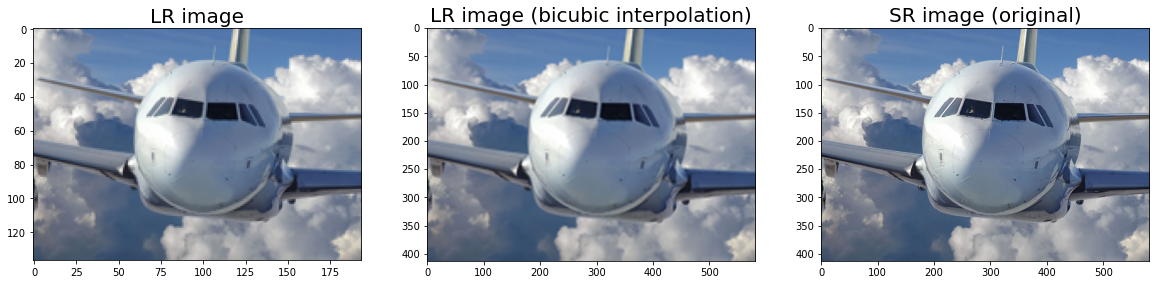

In [8]:
# img_sr = Image.open(img_list_b2[1])
img_sr = Image.open(img_list_g1[1])
img_lr = img_sr.resize((img_sr.width // 3, img_sr.height // 3))
img_int = img_lr.resize((img_sr.width, img_sr.height), resample = Image.BICUBIC)

fig = plt.figure(figsize = (20, 60))
plt.subplot(131)
plt.title('LR image', fontsize = 20)
plt.imshow(img_lr)

plt.subplot(132)
plt.title('LR image (bicubic interpolation)', fontsize = 20)
plt.imshow(img_int)

plt.subplot(133)
plt.title('SR image (original)', fontsize = 20)
plt.imshow(img_sr)

# plt.suptitle('x3')
plt.show()

In [9]:
np_sr = np.array(img_sr)
np_lr = np.array(img_lr)
print(f"np_sr shape : {np_sr.shape}")
print(f"np_lr shape : {np_lr.shape}")

np_sr shape : (413, 582, 3)
np_lr shape : (137, 194, 3)


In [11]:
crop_sr = Image.fromarray(np_sr[150:300, 150:300][:])
crop_lr = Image.fromarray(np_lr[50:100, 50:100][:])

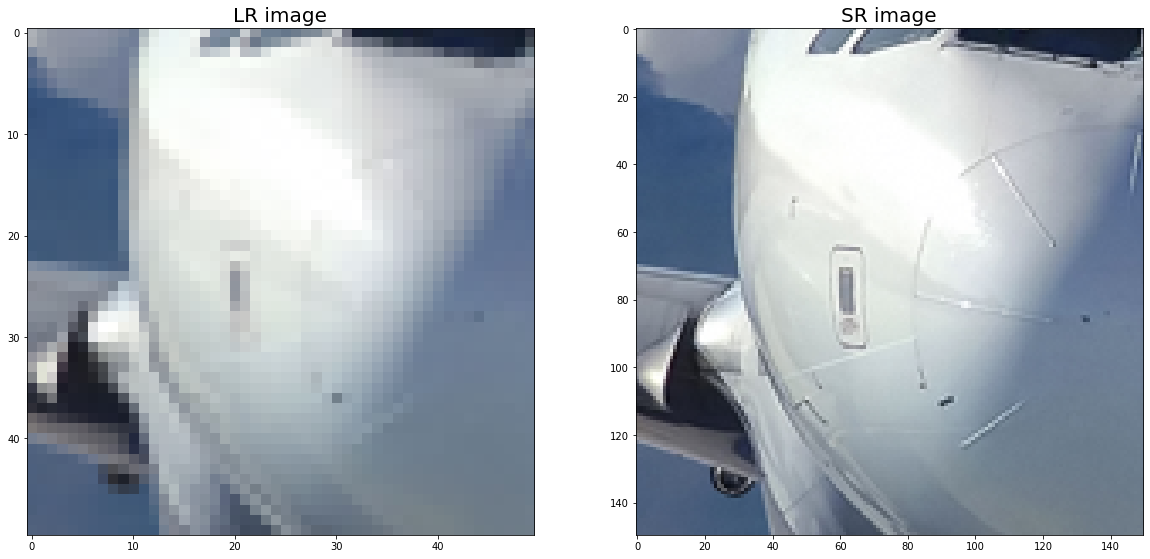

In [12]:
fig = plt.figure(figsize = (20, 40))
plt.subplot(121)
plt.title('LR image', fontsize = 20)
plt.imshow(crop_lr)

plt.subplot(122)
plt.title('SR image', fontsize = 20)
plt.imshow(crop_sr)

## Experiment

Augment:
1. Downscaling [1.0, 0.9, 0.8, 0.7, 0.6]
2. Rotation [0, 90, 180, 270]

▶ 5 x 4 = 20 배

In [104]:
def bname_extract(s):
    s = s.split('/')[-1]
    s = s.split('.')[0]
    return s

In [105]:
bname_extract(img_list_b1[0])

'101085'

In [113]:
downscale_list = [1.0, 0.9, 0.8, 0.7, 0.6]
rotation_list = [0, 90, 180, 270]

lr_mem = []
sr_mem = []
name_mem = []

# scaling factor = 3
# x2는 차이가 덜 뚜렷함
s_factor = 3
patch_size = 30 # lr 기준
lr_stride = 10

for img_path in tqdm(img_list_b2):
    img = Image.open(img_path)
    img_list = []

    # g1 name ex) 001
    # img_name = img_path[-7:-4]

    # b1 name
    img_name = bname_extract(img_path)

    # img_list = 20 augmentated image
    for ds in downscale_list:
        for theta in rotation_list:
            temp = img.resize((int(img.width * ds), int(img.height * ds)), resample = Image.BICUBIC)
            temp = temp.rotate(angle = theta)

            # scaling_factor remain 제거
            temp = temp.resize(((temp.width // s_factor) * s_factor, (temp.height // s_factor) * s_factor),
                                   resample = Image.BICUBIC)
            img_list.append(temp)
    
    for sr_image in img_list:
        lr_image = sr_image.resize((sr_image.width // s_factor, sr_image.height // s_factor), 
                                   resample = Image.BICUBIC)
        sr_np = np.array(sr_image)
        lr_np = np.array(lr_image)

        for y in range(0, lr_np.shape[0] - patch_size + 1, lr_stride):
            for x in range(0, lr_np.shape[1] - patch_size + 1, lr_stride):
                lr_patch = lr_np[y : y + patch_size, x : x + patch_size]
                sr_patch = sr_np[y * s_factor : (y + patch_size) * s_factor,
                                 x * s_factor : (x + patch_size) * s_factor]
                name_patch = {}
                name_patch['img_name'] = img_name
                name_patch['lr_x'] = x
                name_patch['lr_y'] = y
                name_patch['s_factor'] = s_factor

                lr_mem.append(lr_patch)
                sr_mem.append(sr_patch)
                name_mem.append(name_patch)


100%|██████████| 200/200 [01:20<00:00,  2.47it/s]


In [114]:
print(f"lr_mem shape: {len(lr_mem)}")
print(f"sr_mem shape: {len(sr_mem)}")

lr_mem shape: 263200
sr_mem shape: 263200


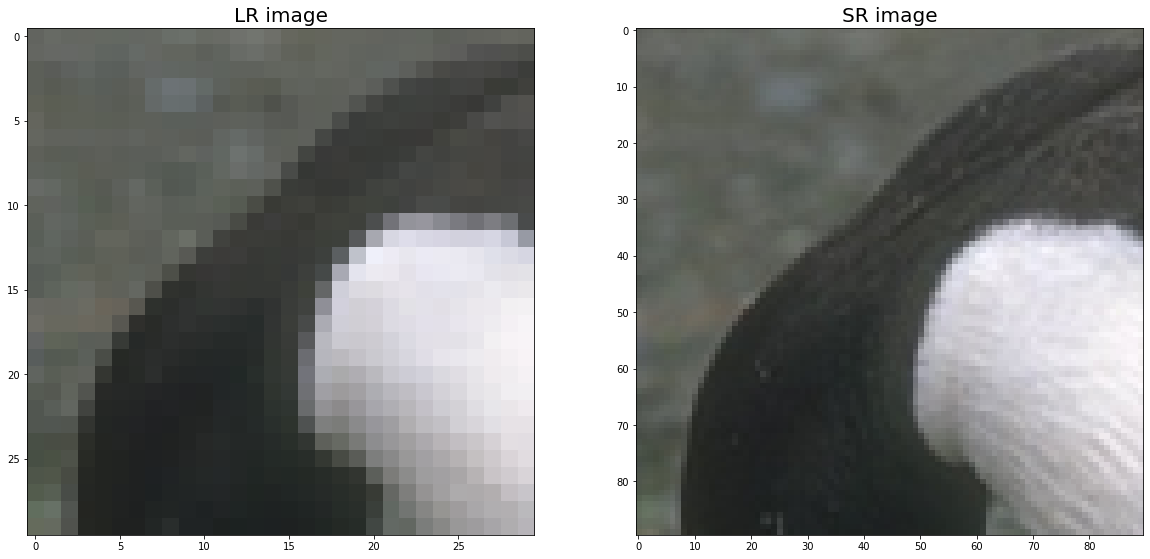

In [118]:
fig = plt.figure(figsize = (20, 40))

sr_sample = sr_mem[10000]
lr_sample = lr_mem[10000]

plt.subplot(121)
plt.title('LR image', fontsize = 20)
plt.imshow(Image.fromarray(lr_sample))

plt.subplot(122)
plt.title('SR image', fontsize = 20)
plt.imshow(Image.fromarray(sr_sample))

In [116]:
# patch 저장
# joblib.dump(lr_mem, '/content/drive/MyDrive/Implement/data/SISR/BSDS200/FSRCNN/lr_mem.pkl')
# joblib.dump(sr_mem, '/content/drive/MyDrive/Implement/data/SISR/BSDS200/FSRCNN/sr_mem.pkl')
# joblib.dump(name_mem, '/content/drive/MyDrive/Implement/data/SISR/BSDS200/FSRCNN/name_mem.pkl')

['/content/drive/MyDrive/Implement/data/SISR/BSDS200/FSRCNN/name_mem.pkl']

In [35]:
A = [[1], [2]]
B = [[2], [2], [3]]

A = A + B
print(A)

[[1], [2], [2], [2], [3]]


In [37]:
class patch_dataset(Dataset):
    def __init__(self, name):
        self.name = name
        if self.name == 'General100':
            self.data = joblib.load(config.dataset_G100 + 'lr_mem.pkl')
            self.target = joblib.load(config.dataset_G100 + 'sr_mem.pkl')
            self.info = joblib.load(config.dataset_G100 + 'name_mem.pkl')
        elif self.name == 'BSDS100':
            self.data = joblib.load(config.dataset_B100 + 'lr_mem.pkl')
            self.target = joblib.load(config.dataset_B100 + 'sr_mem.pkl')
            self.info = joblib.load(config.dataset_B100 + 'name_mem.pkl')
        elif self.name == 'BSDS200':
            self.data = joblib.load(config.dataset_B200 + 'lr_mem.pkl')
            self.target = joblib.load(config.dataset_B200 + 'sr_mem.pkl')
            self.info = joblib.load(config.dataset_B200 + 'name_mem.pkl')
        elif self.name == 'G&B':
            self.data = joblib.load(config.dataset_G100 + 'lr_mem.pkl') + joblib.load(config.dataset_B200 + 'lr_mem.pkl')
            self.target = joblib.load(config.dataset_G100 + 'sr_mem.pkl') + joblib.load(config.dataset_B200 + 'sr_mem.pkl')
            self.info = joblib.load(config.dataset_G100 + 'name_mem.pkl') + joblib.load(config.dataset_B200 + 'name_mem.pkl')
        self.pp = config.augmentation

    def __getitem__(self, idx):
        # lr(input), sr(output), info(name dict)
        
        return self.pp(self.data[idx]), self.pp(self.target[idx]), self.info[idx]

    def __len__(self):
        return len(self.info)

deconv padding setting

https://pytorch.org/docs/master/generated/torch.nn.ConvTranspose2d.html?highlight=convtranspose#torch.nn.ConvTranspose2d

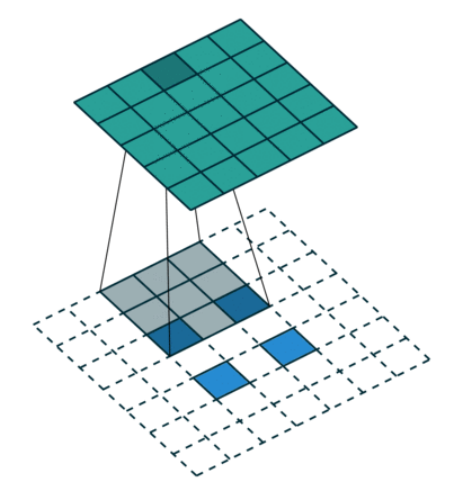

In [141]:
deconv = nn.ConvTranspose2d(10, 3, kernel_size = 9, stride = 3, padding = 4, output_padding = 2)
sample = torch.ones((1, 10, 30, 30))
print(f"deconv(sample).shape : {deconv(sample).shape}")

deconv(sample).shape : torch.Size([1, 3, 90, 90])


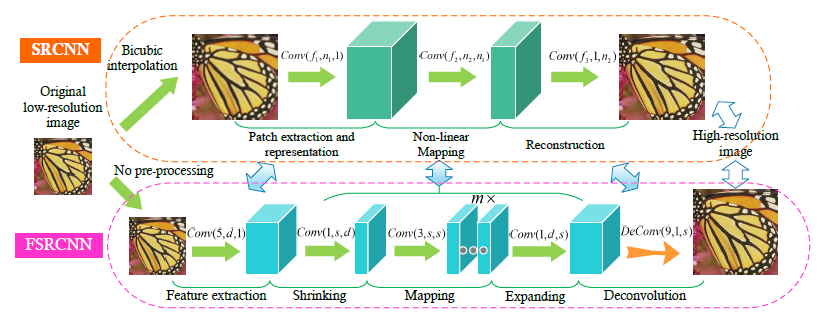

In [10]:
class FSRCNN(nn.Module):
    def __init__(self, s_factor = 3, d = 56, s = 16, m = 4):
        super(FSRCNN, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, d, kernel_size = 5, stride = 1, padding = 2),
            nn.PReLU(d) # nChannels
            )
        self.shrinking = nn.Sequential(
            nn.Conv2d(d, s, kernel_size = 1, stride = 1, padding = 0),
            nn.PReLU(s)
        )
        self.mapping_list = []
        for _ in range(m):
            self.mapping_list.append(nn.Conv2d(s, s, kernel_size = 3, stride = 1, padding = 1))
            self.mapping_list.append(nn.PReLU(s))
        self.mapping = nn.Sequential(*self.mapping_list)
        self.expanding = nn.Sequential(
            nn.Conv2d(s, d, kernel_size = 1, stride = 1, padding = 0),
            nn.PReLU(d)
        )
        self.deconvolution = nn.ConvTranspose2d(d, 3, kernel_size = 9,
                                                stride = s_factor,
                                                padding = 4,
                                                output_padding = s_factor - 1)
    
    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.shrinking(x)
        x = self.mapping(x)
        x = self.expanding(x)
        x = self.deconvolution(x)

        return x


In [168]:
next(iter(train_loader))[0].shape

torch.Size([64, 3, 30, 30])

In [167]:
train_loader = DataLoader(patch_dataset(name = 'General100'), batch_size = config.batch_size, shuffle = True)
test_loader = DataLoader(patch_dataset(name = 'BSDS100'), batch_size = config.batch_size, shuffle = True)

In [154]:
model = FSRCNN(s_factor = 3, d = 56, s = 16, m = 4).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = config.learning_rate, betas = (config.b1, config.b2))

In [173]:
for epoch in range(config.n_epoch):
    print("\nEpoch ", epoch)
    # train
    print("\nTrain:")
    model.train()
    train_loss = 0
    for i, (lr_images, targets, _) in enumerate(train_loader): 
        lr_images, targets = lr_images.to(device), targets.to(device)
        sr_images = model(lr_images)
        loss = criterion(sr_images, targets)    
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ((i+1) % (len(train_loader) // 3) == 1) or i+1 == len(train_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(train_loader), train_loss/(i+1)))
    # val
    print("\nValidation")
    model.eval()
    val_loss = 0
    for i, (lr_images, targets, _) in enumerate(test_loader):
        lr_images, targets = lr_images.to(device), targets.to(device)
        sr_images = model(lr_images)
        loss = criterion(sr_images, targets)   
        val_loss += loss.item()

        if ((i+1) % (len(test_loader) // 3) == 1) or i+1 == len(test_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(test_loader), val_loss/(i+1)))


        



Epoch  0

Train:
[  1/2652] | Loss: 0.00887
[885/2652] | Loss: 0.02493
[1769/2652] | Loss: 0.01985
[2652/2652] | Loss: 0.01672

Validation
[  1/2057] | Loss: 0.01126
[686/2057] | Loss: 0.01151
[1371/2057] | Loss: 0.01151
[2056/2057] | Loss: 0.01152
[2057/2057] | Loss: 0.01152

Epoch  1

Train:
[  1/2652] | Loss: 0.00976
[885/2652] | Loss: 0.00929
[1769/2652] | Loss: 0.00921
[2652/2652] | Loss: 0.00905

Validation
[  1/2057] | Loss: 0.01212
[686/2057] | Loss: 0.01072
[1371/2057] | Loss: 0.01067
[2056/2057] | Loss: 0.01067
[2057/2057] | Loss: 0.01066

Epoch  2

Train:
[  1/2652] | Loss: 0.00739
[885/2652] | Loss: 0.00848
[1769/2652] | Loss: 0.00844
[2652/2652] | Loss: 0.01490

Validation
[  1/2057] | Loss: 0.02602
[686/2057] | Loss: 0.02643
[1371/2057] | Loss: 0.02643
[2056/2057] | Loss: 0.02640
[2057/2057] | Loss: 0.02640

Epoch  3

Train:
[  1/2652] | Loss: 0.02621
[885/2652] | Loss: 0.01508
[1769/2652] | Loss: 0.01272
[2652/2652] | Loss: 0.01161

Validation
[  1/2057] | Loss: 0.01070

In [174]:
model = model.to('cpu')
torch.save(model.state_dict(), '/content/drive/MyDrive/Implement/FSRCNN/model_1.pth')

In [14]:
# Test
model = FSRCNN()
model.load_state_dict(torch.load('/content/drive/MyDrive/Implement/FSRCNN/model_1.pth'))

<All keys matched successfully>

### G1 dataset Completed
### => B2 dataset transfer learning

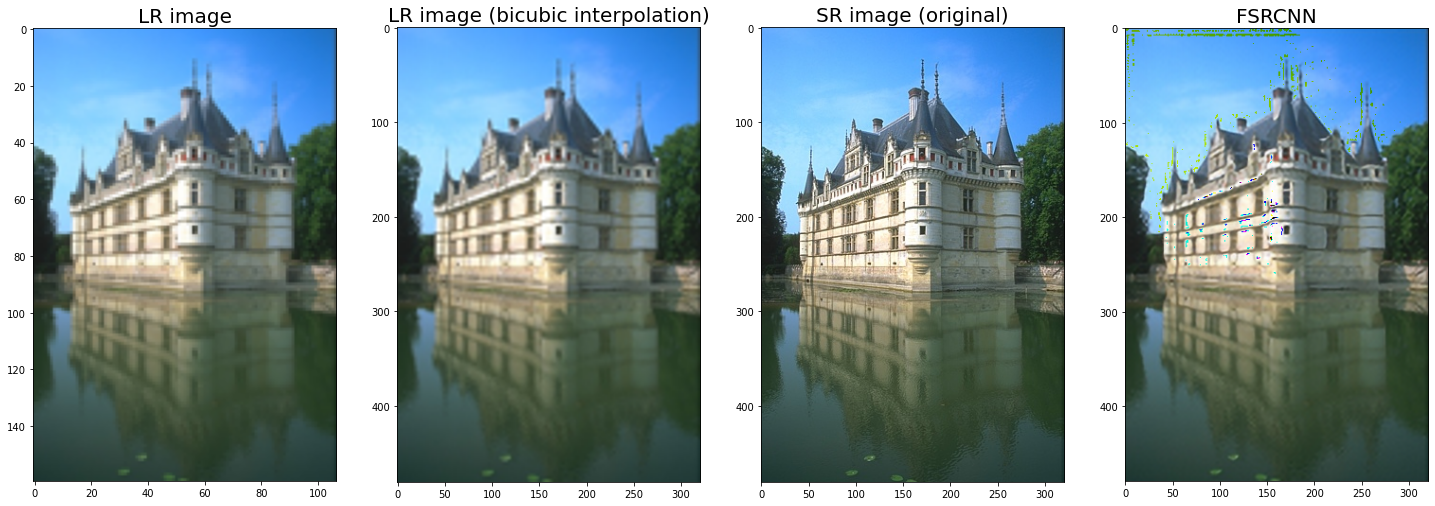

In [47]:
# img_sr = Image.open(img_list_b2[1])
img_sr = Image.open(img_list_b1[2])
img_lr = img_sr.resize((img_sr.width // 3, img_sr.height // 3))
img_int = img_lr.resize((img_sr.width, img_sr.height), resample = Image.BICUBIC)

lr_numpy = np.array(img_lr)
lr_t = config.augmentation(lr_numpy)
output = model(lr_t.unsqueeze(0))
output = output.squeeze(0)
output = config.denormalize(output)
output = torchvision.transforms.ToPILImage()(output)

fig = plt.figure(figsize = (25, 100))
plt.subplot(141)
plt.title('LR image', fontsize = 20)
plt.imshow(img_lr)

plt.subplot(142)
plt.title('LR image (bicubic interpolation)', fontsize = 20)
plt.imshow(img_int)

plt.subplot(143)
plt.title('SR image (original)', fontsize = 20)
plt.imshow(img_sr)

plt.subplot(144)
plt.title('FSRCNN', fontsize = 20)
plt.imshow(output)
plt.show()

In [38]:
train_loader = DataLoader(patch_dataset(name = 'G&B'), batch_size = config.batch_size, shuffle = True)

In [39]:
model = FSRCNN()
model.load_state_dict(torch.load('/content/drive/MyDrive/Implement/FSRCNN/model_1.pth'))

<All keys matched successfully>

In [42]:
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = config.learning_rate, betas = (config.b1, config.b2))

In [43]:
for epoch in range(config.n_epoch):
    print("\nEpoch ", epoch)
    # train
    print("\nTrain:")
    model.train()
    train_loss = 0
    for i, (lr_images, targets, _) in enumerate(train_loader): 
        lr_images, targets = lr_images.to(device), targets.to(device)
        sr_images = model(lr_images)
        loss = criterion(sr_images, targets)    
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ((i+1) % (len(train_loader) // 3) == 1) or i+1 == len(train_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(train_loader), train_loss/(i+1)))


Epoch  0

Train:
[  1/6764] | Loss: 0.00816
[2255/6764] | Loss: 0.01028
[4509/6764] | Loss: 0.00956
[6763/6764] | Loss: 0.00904
[6764/6764] | Loss: 0.00904

Epoch  1

Train:
[  1/6764] | Loss: 0.00751
[2255/6764] | Loss: 0.00767
[4509/6764] | Loss: 0.00763
[6763/6764] | Loss: 0.01377
[6764/6764] | Loss: 0.01377

Epoch  2

Train:
[  1/6764] | Loss: 0.02258
[2255/6764] | Loss: 0.01267
[4509/6764] | Loss: 0.01124
[6763/6764] | Loss: 0.01046
[6764/6764] | Loss: 0.01046

Epoch  3

Train:
[  1/6764] | Loss: 0.00791
[2255/6764] | Loss: 0.00802
[4509/6764] | Loss: 0.00782
[6763/6764] | Loss: 0.00772
[6764/6764] | Loss: 0.00772

Epoch  4

Train:
[  1/6764] | Loss: 0.00721
[2255/6764] | Loss: 0.02720
[4509/6764] | Loss: 0.01897
[6763/6764] | Loss: 0.01576
[6764/6764] | Loss: 0.01576

Epoch  5

Train:
[  1/6764] | Loss: 0.01060
[2255/6764] | Loss: 0.00848
[4509/6764] | Loss: 0.00818
[6763/6764] | Loss: 0.00800
[6764/6764] | Loss: 0.00800

Epoch  6

Train:
[  1/6764] | Loss: 0.00602
[2255/6764] |

KeyboardInterrupt: ignored

In [53]:
model = model.to('cpu')
torch.save(model.state_dict(), '/content/drive/MyDrive/Implement/FSRCNN/model_2.pth')

In [11]:
model = FSRCNN()
model.load_state_dict(torch.load('/content/drive/MyDrive/Implement/FSRCNN/model_2.pth'))

<All keys matched successfully>

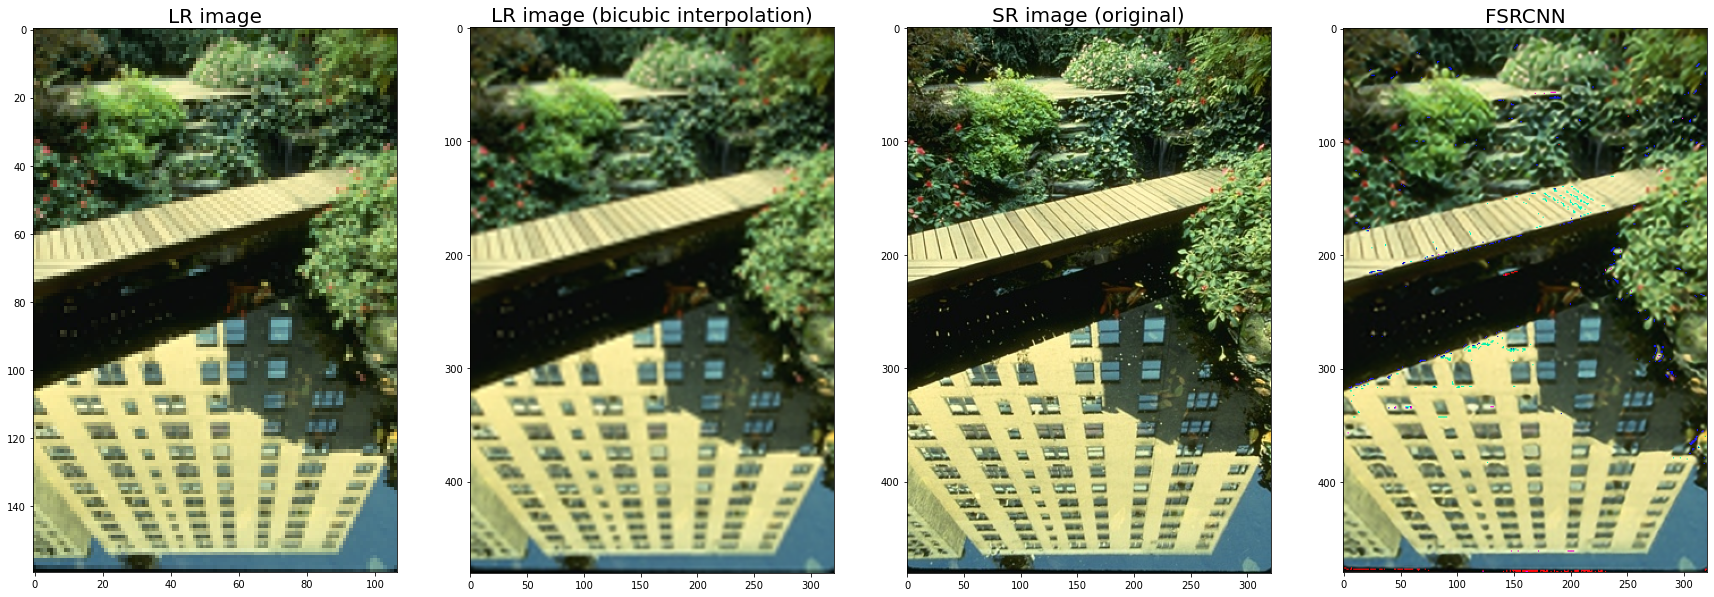

In [15]:
# img_sr = Image.open(img_list_b2[1])
# 10 11 12 15 // 
img_sr = Image.open(img_list_b1[20])
img_lr = img_sr.resize((img_sr.width // 3, img_sr.height // 3))
img_int = img_lr.resize((img_sr.width, img_sr.height), resample = Image.BICUBIC)

lr_numpy = np.array(img_lr)
lr_t = config.augmentation(lr_numpy)
output = model(lr_t.unsqueeze(0))
output = output.squeeze(0)
output = config.denormalize(output)
output = torchvision.transforms.ToPILImage()(output)

fig = plt.figure(figsize = (30, 120))
plt.subplot(141)
plt.title('LR image', fontsize = 20)
plt.imshow(img_lr)

plt.subplot(142)
plt.title('LR image (bicubic interpolation)', fontsize = 20)
plt.imshow(img_int)

plt.subplot(143)
plt.title('SR image (original)', fontsize = 20)
plt.imshow(img_sr)

plt.subplot(144)
plt.title('FSRCNN', fontsize = 20)
plt.imshow(output)
plt.show()